In [1]:
# Import libraries
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-25 14:43:59.968917: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 14:43:59.971443: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 14:44:00.009391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 14:44:00.009439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 14:44:00.009477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# Set directories
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, "mosquitoes-dataset")

In [3]:
IMG_SIZE = (160, 160)

In [4]:
# Load data
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                               seed=1234,
                                                               validation_split=0.2,
                                                               subset='both',
                                                               batch_size=32,
                                                               image_size=IMG_SIZE,
                                                               )

Found 1201 files belonging to 2 classes.
Using 961 files for training.
Using 240 files for validation.


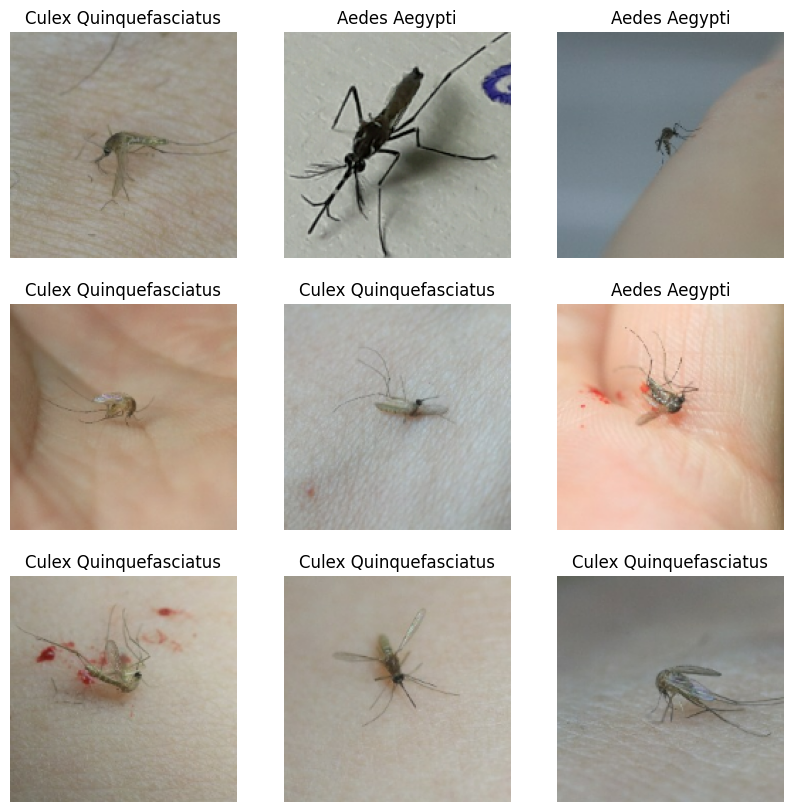

In [5]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
# Data augmentation
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

In [7]:
# Image normalization
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               )

In [10]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augment(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [17]:
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              )

In [18]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

8/8 [==============================] - 3s 185ms/step - loss: 0.9630 - accuracy: 0.4667


In [19]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    )

Epoch 1/10
31/31 [==============================] - 10s 226ms/step - loss: 0.8862 - accuracy: 0.4984 - val_loss: 0.8275 - val_accuracy: 0.4500
Epoch 2/10
31/31 [==============================] - 8s 220ms/step - loss: 0.7752 - accuracy: 0.5598 - val_loss: 0.7459 - val_accuracy: 0.5417
Epoch 3/10
31/31 [==============================] - 8s 220ms/step - loss: 0.7004 - accuracy: 0.6181 - val_loss: 0.6829 - val_accuracy: 0.6000
Epoch 4/10
31/31 [==============================] - 8s 220ms/step - loss: 0.6770 - accuracy: 0.6493 - val_loss: 0.6248 - val_accuracy: 0.6542
Epoch 5/10
31/31 [==============================] - 8s 227ms/step - loss: 0.5757 - accuracy: 0.7097 - val_loss: 0.5800 - val_accuracy: 0.6958
Epoch 6/10
31/31 [==============================] - 8s 224ms/step - loss: 0.5644 - accuracy: 0.7201 - val_loss: 0.5430 - val_accuracy: 0.7292
Epoch 7/10
31/31 [==============================] - 8s 225ms/step - loss: 0.5400 - accuracy: 0.7284 - val_loss: 0.5093 - val_accuracy: 0.7500
Epoch

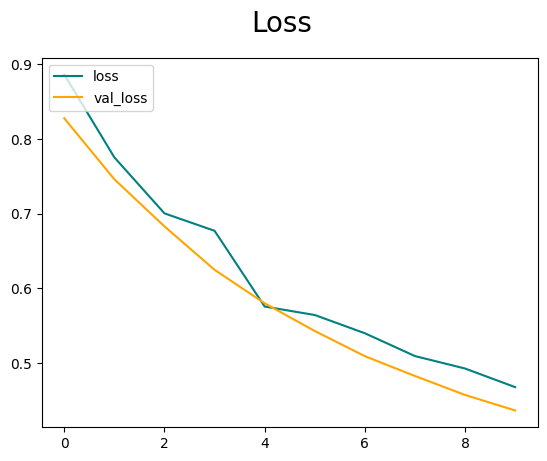

In [20]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

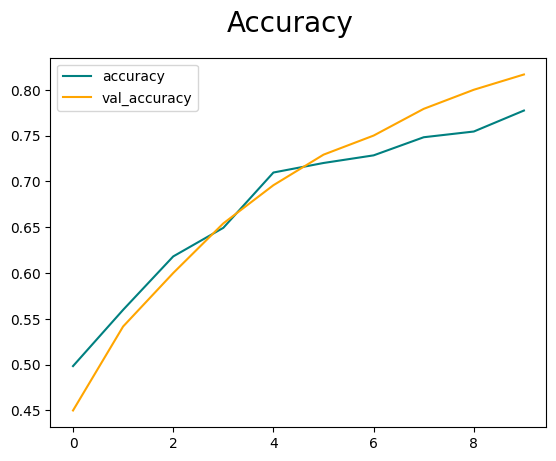

In [30]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
base_model.trainable = True
fine_tune_layers = 120

In [22]:
for layer in base_model.layers[:fine_tune_layers]:
    layer.trainable = False

In [23]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [24]:
len(model.trainable_variables)

38

In [25]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)


Epoch 10/20
31/31 [==============================] - 13s 276ms/step - loss: 0.3704 - accuracy: 0.8293 - val_loss: 0.2662 - val_accuracy: 0.9042
Epoch 11/20
31/31 [==============================] - 9s 244ms/step - loss: 0.3310 - accuracy: 0.8554 - val_loss: 0.2236 - val_accuracy: 0.9167
Epoch 12/20
31/31 [==============================] - 9s 242ms/step - loss: 0.2526 - accuracy: 0.8939 - val_loss: 0.2038 - val_accuracy: 0.9333
Epoch 13/20
31/31 [==============================] - 9s 244ms/step - loss: 0.2268 - accuracy: 0.8991 - val_loss: 0.1889 - val_accuracy: 0.9333
Epoch 14/20
31/31 [==============================] - 9s 241ms/step - loss: 0.2403 - accuracy: 0.9084 - val_loss: 0.1650 - val_accuracy: 0.9542
Epoch 15/20
31/31 [==============================] - 9s 240ms/step - loss: 0.1915 - accuracy: 0.9199 - val_loss: 0.1647 - val_accuracy: 0.9417
Epoch 16/20
31/31 [==============================] - 8s 240ms/step - loss: 0.1771 - accuracy: 0.9240 - val_loss: 0.1658 - val_accuracy: 0.933

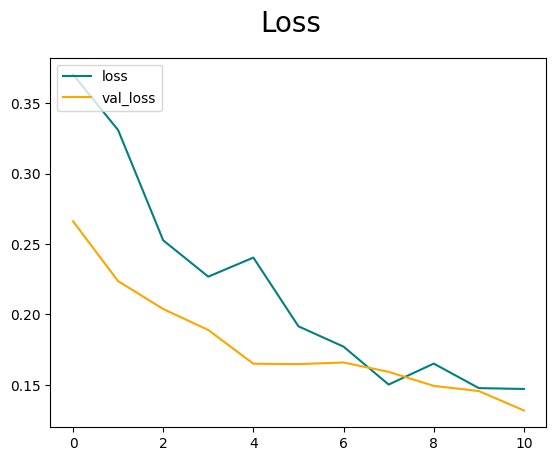

In [26]:
fig = plt.figure()
plt.plot(history_fine.history['loss'], color='teal', label='loss')
plt.plot(history_fine.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

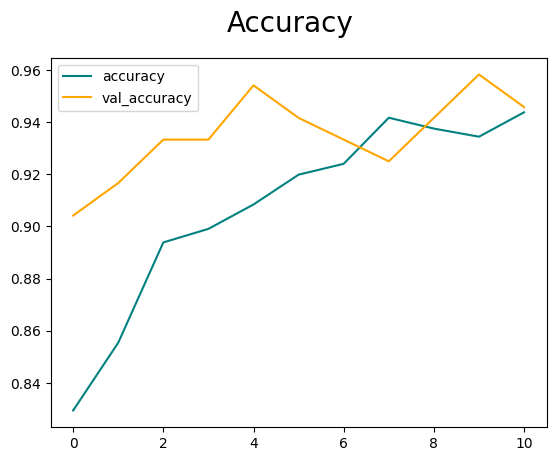

In [27]:
fig = plt.figure()
plt.plot(history_fine.history['accuracy'], color='teal', label='accuracy')
plt.plot(history_fine.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

1/1 [==============================] - 0s 29ms/step


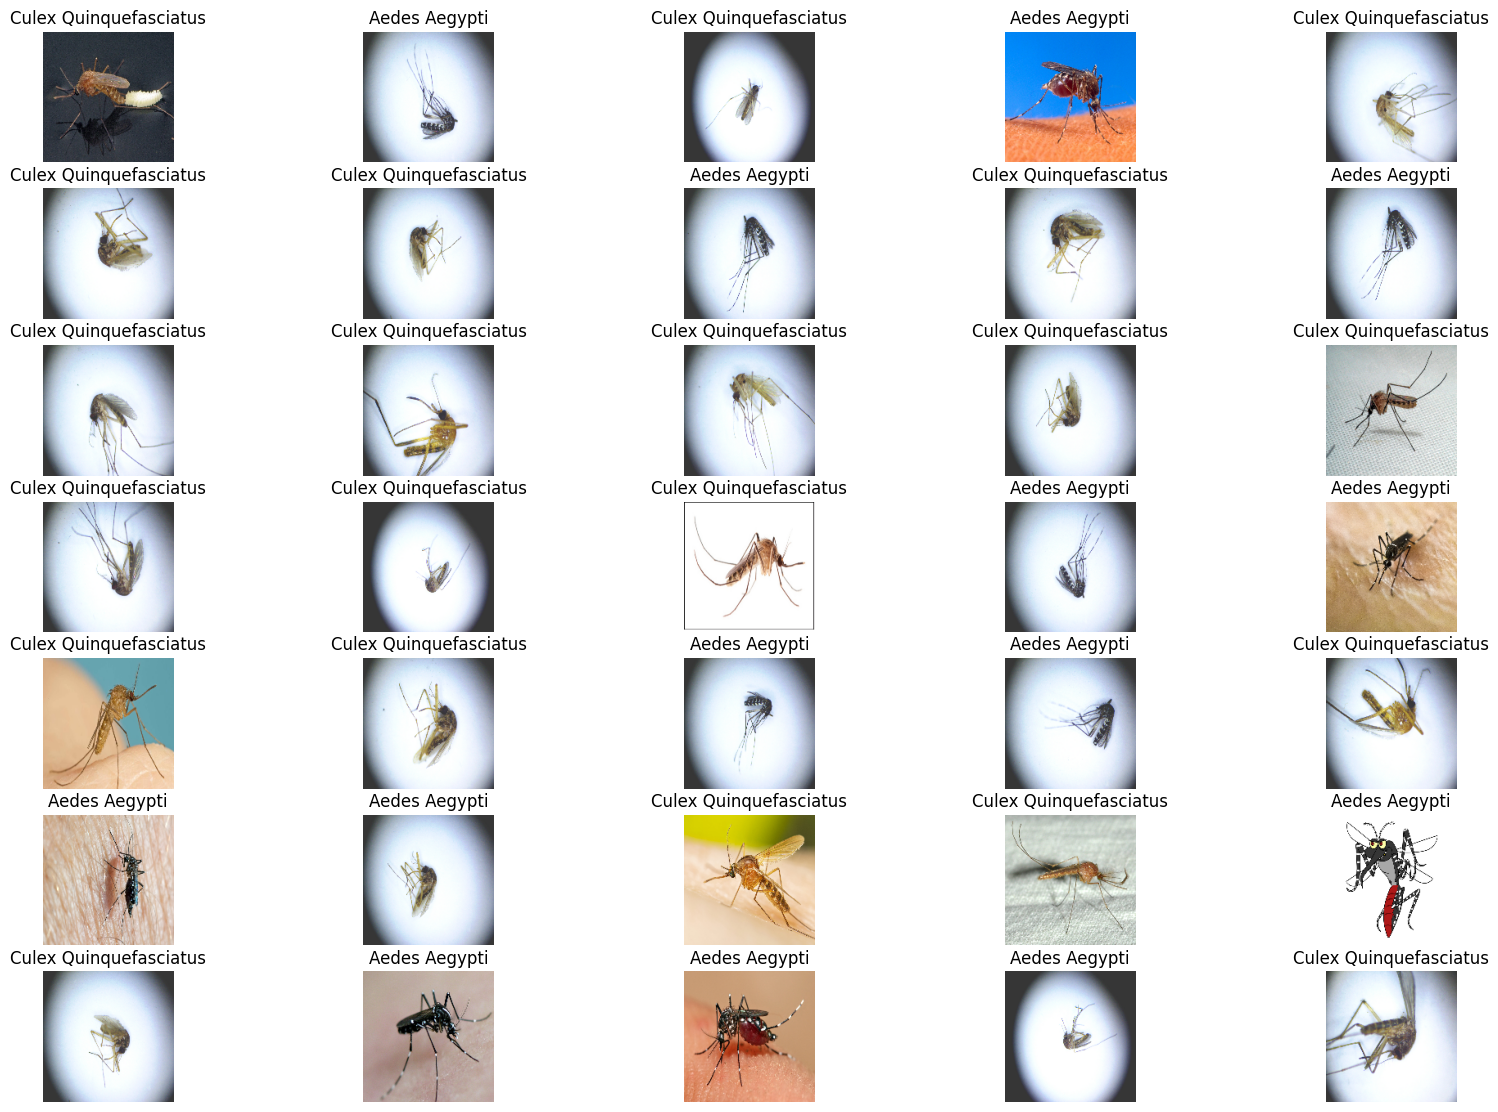

In [33]:
test_dir = os.path.join(root_dir, "test-dataset")

plt.figure(figsize=(20, 20))
for index, image in enumerate(os.listdir(test_dir)):
    img = cv2.imread(os.path.join(test_dir, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, IMG_SIZE)

    yhat = model.predict(np.expand_dims(img, 0))
    yhat = tf.nn.softmax(yhat[0])
    yhat = np.array(yhat)
    plt.subplot(10, 5, index + 1)
    plt.imshow(img.numpy().astype('uint8'))
    plt.title(class_names[np.argmax(yhat)])
    plt.axis("off")

In [29]:
model.save(os.path.join(root_dir, "models", "pretrained_multiclass_model.keras"))